# Salem paper attacks

This notebook showcases the three different scenarios presented in Salem *et al.* [ML-Leaks: Model and Data Independent Membership Inference Attacks and Defenses on Machine Learning Models](https://arxiv.org/abs/1806.01246).

In summary the three presented adversaries are as follows:
1. The attacker has access to a dataset drawn from the same distribution as the target data, and uses it to train a single shadow model that infers the membership information.
2. The attacker uses a dataset from a different distribution than the target data to do the same as Adv 1.
3. The attacker queries the target model and chooses a threshold on the classification probability to determine membership, no shadow models required.

In [1]:
import sys
import os

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Scikit-learn utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# Classifiers for attack models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


2022-05-04 08:41:37.068997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-04 08:41:37.069051: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#import t=privachy version 
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy


### Definition of the datasets
1. We draw data points from a distribution.
2. We split these data points into the target dataset and a shadow dataset drawn from the same distribution.
3. We also draw a dataset from a different distribution.

**NOTE**. ***I make datasets with few samples but with many features to force the target model to overfit.***


***NOTE JIM: had to make batch_size 25 so DP optimizer would run with same hyperparams

In [4]:
n_classes = 2

# (X,y): Original distribution
X, y = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=15
                          )
# One-hot encoding of the label
y = np.eye(n_classes)[y]

# (Xt, yt) is the target dataset, owned by the TRE and drawn from the (X,y) distribution
# (Xs, ys) is a shadow dataset drawn from the (X,y) distribution
Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.50, random_state=15)

# (Xd, yd) is a shadow dataset, drawn from a different distribution (different seed)
Xd, yd = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=42
                          )
yd = np.eye(n_classes)[yd]




### Train the target model

*Again, I'm using a rather big model (for the classification task) to favour overfitting.*

In [5]:
# Split into train (member) and test (non-member) datasets
# Set shuffle to False so that Xt_membership is consistent with Xt, otherwise
# we need to stack Xt_member and Xt_nonmember again to get a consistent Xt.
Xt_member, Xt_nonmember, yt_member, yt_nonmember = train_test_split(Xt, yt, test_size=0.5, shuffle=False)

# Set membership status for future tests
Xt_membership = np.vstack(
    (
        np.ones((Xt_member.shape[0], 1), np.uint8),
        np.zeros((Xt_nonmember.shape[0], 1), np.uint8)
    )
).flatten()

# Define target model
# Tensorflow model (MLP) (making it big to make it overfit)
input_data = Input(shape = Xt_member[0].shape)
x = Dense(128, activation='relu')(input_data)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

target_model = Model(input_data, output)
target_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


batch_size=25
epochs = 10

# Train target model
r = target_model.fit(Xt_member, 
                     yt_member, 
                     validation_data=(Xt_nonmember, yt_nonmember),
                     epochs=epochs, 
                     batch_size=batch_size
                    )  

Epoch 1/10


2022-05-04 08:41:43.509372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-04 08:41:43.509431: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-04 08:41:43.509462: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-05-04 08:41:43.509835: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


10/10 [==============================] - 1s 48ms/step - loss: 3.3409 - accuracy: 0.4800 - val_loss: 2.3620 - val_accuracy: 0.5240
Epoch 2/10
10/10 [==============================] - 0s 20ms/step - loss: 0.4757 - accuracy: 0.8280 - val_loss: 1.5756 - val_accuracy: 0.5800
Epoch 3/10
10/10 [==============================] - 0s 18ms/step - loss: 0.1099 - accuracy: 0.9520 - val_loss: 1.4392 - val_accuracy: 0.5720
Epoch 4/10
10/10 [==============================] - 0s 20ms/step - loss: 0.0300 - accuracy: 0.9960 - val_loss: 1.4932 - val_accuracy: 0.5800
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.3258 - val_accuracy: 0.6000
Epoch 6/10
10/10 [==============================] - 0s 21ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.2999 - val_accuracy: 0.6200
Epoch 7/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.2994 - val_accuracy: 0.6200
Epoch 8/10
10/10 [======

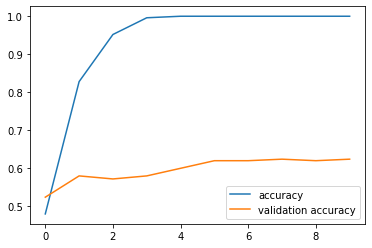

In [6]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

**SUCCESS. The model overfits a lot.**

## So now let's see what we can find out about this model if it is exported just be querying it

In [7]:
target_model.__dict__

{'_self_setattr_tracking': True,
 '_is_model_for_instrumentation': True,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': False,
 '_instrumented_keras_model_class': True,
 '_trainable': True,
 '_stateful': False,
 'built': True,
 '_input_spec': None,
 '_build_input_shape': TensorShape([None, 300]),
 '_saved_model_inputs_spec': TensorSpec(shape=(None, 300), dtype=tf.float32, name='input_1'),
 '_saved_model_arg_spec': ([TensorSpec(shape=(None, 300), dtype=tf.float32, name='input_1')],
  {}),
 '_supports_masking': True,
 '_name': 'model',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x7fe519bc3590>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7fe50cc8db10>,
 '_dtype_policy': <Policy "float32">,
 '_compute_dtype_object': tf.float32,
 '_autocast': False,
 '_self_tracked_trackables': [<keras.engine.input_lay

### in particular, as well as all the config details and weights, we can see this was not compiled with the DP version of the optimiser
 - and if we print target_model.optimizer.__dict__ we get even mor detail

In [8]:

print(f'trained model has this type of optimiser {type(target_model.optimizer)}')
print( 'and the loss function is {target_model.loss}')
print(target_model.optimizer._name)

saved_nonDP_optimiser_dict= target_model.optimizer.__dict__

test_loss, test_acc = target_model.evaluate(Xs,  ys, verbose=2)
print(f'before hacking the model attributes test loss is {test_loss} test accuracy is {test_acc}')



trained model has this type of optimiser <class 'keras.optimizer_v2.adam.Adam'>
and the loss function is {target_model.loss}
Adam
16/16 - 0s - loss: 1.4632 - accuracy: 0.6020 - 292ms/epoch - 18ms/step
before hacking the model attributes test loss is 1.4632388353347778 test accuracy is 0.6019999980926514


### so ...
We could easily:
- write a code that tested the model looking to see if it used for the DP optimiser 
- make it available via `preliminaryCheck()` and `requestRelease()`

But what if a researcher tries to change the optimiser afterwards, but forgets to retrain?

**Q** check if malicious user could change min_split_size perior to calling fit() then change back afterwards in sklearn safe version


**panicking user follows advice from** https://www.tensorflow.org/responsible_ai/privacy/tutorials/classification_privacy

- define some params
- Define the optimizer and loss function for the learning model. 

- Compute the loss as a vector of losses per-example rather than as the mean over a minibatch to support gradient manipulation over each training point.

In [9]:
###user manually creates DP optimiser and resets model
#some params
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = batch_size
learning_rate = 0.25


if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

#create the optimiser and loss function

optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [10]:
# now try to manually assign these values to the target_model rather than recompile and refit
import copy
hacked_model = copy.deepcopy(target_model)

hacked_model.optimizer = optimizer
hacked_model.loss = loss

# so what have we got now?

print(f'After hacking the model attributes it now looks like the same trained model has this type of optimiser {hacked_model.optimizer}')


# can we still use it for prediction even after this hacking?
test_loss, test_acc = hacked_model.evaluate(Xs,  ys, verbose=2)
print(f'\n But, importantly, we can still use it to predict: test loss is {test_loss} test accuracy is {test_acc}')




2022-05-04 08:41:47.912185: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://dfc1f7b6-3789-4202-bac6-709d8b992de7/assets
After hacking the model attributes it now looks like the same trained model has this type of optimiser <tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fe50c9d8e50>
16/16 - 0s - loss: 1.4632 - accuracy: 0.6020 - 191ms/epoch - 12ms/step

 But, importantly, we can still use it to predict: test loss is 1.4632388353347778 test accuracy is 0.6019999980926514



### This is what they would have got if they recompiled and reran


Epoch 1/10


/home/andy/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 4s 81ms/step - loss: 4821.9087 - accuracy: 0.5400 - val_loss: 17400.2324 - val_accuracy: 0.4840
Epoch 2/10
10/10 [==============================] - 0s 48ms/step - loss: 26032.7676 - accuracy: 0.5000 - val_loss: 46942.0352 - val_accuracy: 0.4640
Epoch 3/10
10/10 [==============================] - 1s 55ms/step - loss: 63700.9922 - accuracy: 0.5320 - val_loss: 92376.3438 - val_accuracy: 0.4880
Epoch 4/10
10/10 [==============================] - 0s 43ms/step - loss: 103606.9453 - accuracy: 0.5240 - val_loss: 147892.2969 - val_accuracy: 0.4960
Epoch 5/10
10/10 [==============================] - 1s 60ms/step - loss: 132076.3594 - accuracy: 0.5640 - val_loss: 226403.5156 - val_accuracy: 0.4720
Epoch 6/10
10/10 [==============================] - 1s 57ms/step - loss: 206667.3125 - accuracy: 0.5360 - val_loss: 294979.6875 - val_accuracy: 0.4320
Epoch 7/10
10/10 [==============================] - 0s 48ms/step - loss: 225393.5000 - accuracy: 0.5760 - val_lo

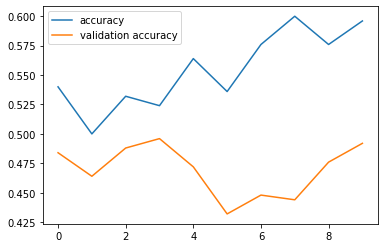

16/16 - 0s - loss: 666839.7500 - accuracy: 0.4880 - 212ms/epoch - 13ms/step

 The DP trained version gets these test results:  test loss is 666839.75 test accuracy is 0.4880000054836273
trained model has this type of optimiser <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
and the loss function is {target_model_DP.loss}


In [11]:


#some params
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = batch_size
learning_rate = 0.25




if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

#create the optimiser and loss function

optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

DP_model = Model(input_data, output)
DP_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])




r_DP = DP_model.fit(Xt_member, 
                     yt_member, 
                     validation_data=(Xt_nonmember, yt_nonmember),
                     epochs=epochs, 
                     batch_size=batch_size
                    )  
                    
plt.plot(r_DP.history['accuracy'], label='accuracy')
plt.plot(r_DP.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()                    
                    
                    
test_loss, test_acc = DP_model.evaluate(Xs,  ys, verbose=2)
print(f'\n The DP trained version gets these test results:  test loss is {test_loss} test accuracy is {test_acc}')


print(f'trained model has this type of optimiser {type(DP_model.optimizer)}')
print( 'and the loss function is {target_model_DP.loss}')
  

## Checks for differential privacy based on flags within model optimizer

In [12]:
#show that DP was not used
def check_DP_used(optimizer):
    DPused = False
    reason = "None"
    if ( "_was_dp_gradients_called" not in optimizer.__dict__ ):
        reason = "optimiser does not contain key _was_dp_gradients_called so is not DP."
        DPused = False
    elif (optimizer._was_dp_gradients_called==False):
        reason= "although the target model optimiser has been changed to a DP variant, fit() has not been rerun."
        DPused = False
    else:
        reason= f" value of the key: target_model.optimizer._was_dp_gradients_called is {optimizer._was_dp_gradients_called} so DP variant of optimiser has been run"
        DPused=True
    return DPused, reason

## So what have we learned?

In [13]:
print("=====For our original non-DP model=====")
the_optimiser = target_model.optimizer
print(f"The optimiser is of type {type(the_optimiser)}, with name {the_optimiser._name}.")
print(f"calling get_config() on this optimizer returns {the_optimiser.get_config()}")
value, reason = check_DP_used(the_optimiser)
print(f"Running our check_DP_used function  gives {value} because {reason}\n")

print(f"=====For the hacked version of original non-DP model=====")
the_optimiser = hacked_model.optimizer      
print(f"The optimiser is of type {type(the_optimiser)}, with name {the_optimiser._name}.")
print(f"calling get_config() on this optimizer returns {the_optimiser.get_config()}")
value, reason = check_DP_used(the_optimiser)
print(f"Running our check_DP_used function  gives {value} because {reason}\n")

print("=====For the DP model =======")
the_optimiser= DP_model.optimizer
print(f"The optimiser is of type {type(the_optimiser)}, with name {the_optimiser._name}.")
print(f"calling get_config() on this optimizer returns {the_optimiser.get_config()}")
value, reason = check_DP_used(the_optimiser)
print(f"Running our check_DP_used function  gives {value} because {reason}\n")

=====For our original non-DP model=====
The optimiser is of type <class 'keras.optimizer_v2.adam.Adam'>, with name Adam.
calling get_config() on this optimizer returns {'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
Running our check_DP_used function  gives False because optimiser does not contain key _was_dp_gradients_called so is not DP.

=====For the hacked version of original non-DP model=====
The optimiser is of type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>, with name SGD.
calling get_config() on this optimizer returns {'name': 'SGD', 'learning_rate': 0.25, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False, 'l2_norm_clip': 1.5, 'noise_multiplier': 1.3, 'num_microbatches': 25}
Running our check_DP_used function  gives False because although the target model optimiser has been changed to a DP variant, fit() has not been rerun.

====

In [14]:
from typing import Any

def check_type(key: str, val: Any, cur_val: Any) -> tuple[str, bool]:
    """Checks the type of a value"""
    print(type(DP_model.optimizer))
    if isinstance(cur_val, val) == False:
        disclosive = True
        msg = (
            f"- parameter {key} = {cur_val}"
            f" identified as different type than the recommended fixed value of {val}."
        )
    else:
        disclosive = False
        msg = ""
    return msg, disclosive




check_type(key="optimizer", val=tensorflow_privacy.DPKerasSGDOptimizer,cur_val = DP_model.optimizer)


<class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>


("- parameter optimizer = <tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fe50c5b8d00> identified as different type than the recommended fixed value of <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>.",
 True)

### so the test accuracy is now significantly reduced if they properly recompile and retrain using the DP code

### and what is the nominal privacy?

In [15]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=Xt.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1e-5)

DP-SGD with sampling rate = 5% and noise_multiplier = 1.3 iterated over 200 steps satisfies differential privacy with eps = 3.28 and delta = 1e-05.
The optimal RDP order is 6.0.


(3.284184302269499, 6.0)

## Now try the SafeKerasModel version

In [29]:
import  importlib, safemodel
""", safemodel, Safe_Keras"""

from safemodel.safemodel import SafeModel
from safemodel.classifiers import Safe_KerasModel


importlib.reload(safemodel.safemodel)


<module 'safemodel.safemodel' from '/home/andy/GRAIMatter/safemodel/safemodel.py'>

In [32]:
optimizer=None
safeModel = Safe_KerasModel(input, output)


TypeError: module() argument 'name' must be str, not Safe_KerasModel

In [26]:
#safeModel.__dict__


In [27]:
safeModel.compile()#optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(safeModel.optimizer)



NameError: name 'safeModel' is not defined

In [ ]:
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = batch_size
learning_rate = 0.25




if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

#create the optimiser and loss function

optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)